# Предсказываем автора вопроса спортивного ЧГК по тексту вопроса

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
from multiprocessing.dummy import Pool
from lxml.html import fromstring
from lxml import cssselect
import numpy as np


Сгенерим по 20 адресов страниц поисковой выдачи для каждого из двух авторов, чтобы в итоге получить около тысячи вопросов для кждого.

In [3]:
url_template = 'http://db.chgk.info/search/questions/author_{}/types1/Q?page={}'
urls = []
for author in ['mmatveev', 'akolesov']:
    for page in range(0,20):
        urls.append(url_template.format(author, page))
        
flatten = lambda l: [item for sublist in l for item in sublist]   

Скачаем тексты вопросов и приведем в удобоваримый вид, оставив только текст вопроса (без ответа, комментариев, источника и т.д.)

In [4]:
text = ''
for url in urls:
    html = requests.get(url).text
    dom = fromstring(html)
    dom.make_links_absolute(url)
    css_elements = flatten (dom.cssselect('.questions-results'))
    text += "----------".join([t.text_content().strip() for t in css_elements])
    
with open('вопросы.txt', 'w') as f:
    f.write(text)

In [5]:
text_list = [x for x in text.split('----------')]
data = pd.Series(text_list).to_frame('Text')

In [6]:
data = data[data['Text'].str.contains('Вопрос ')]

In [7]:
data = data['Text'].str.split('Автор: ', expand = True)

In [8]:
data.columns = ['Text', 'Author']
data.dropna(inplace=True)

Сразу заменим наши классы на 0 и 1.

In [9]:
# 0 - Матвеев
# 1 - Колесов
data['Author'] = data['Author'].apply(lambda x: 1 if x.startswith('Артем Колесов') else 0)

In [10]:
data.Author.value_counts()

1    960
0    938
Name: Author, dtype: int64

In [11]:
data['Question'] = data['Text'].str.split('Ответ: ', expand = True, n = 1)[0]
data.drop('Text', axis=1, inplace=True)
data.reset_index(inplace=True, drop=True)

In [12]:
data['Question'] = data['Question'].str.split(': ', expand = True, n = 1)[1]
data.head()

,Author,Question
0,0,"Вопрос посвящается клубу ""Дети Коломны"".\n\n ..."
1,0,"Вопрос посвящается Антону МирошничЕнко, ветера..."
2,0,"Вопрос посвящается Наталье РыжАновой, которая ..."
3,0,"Вопрос посвящается Антону ГубАнову, астроному ..."
4,0,"Вопрос посвящается Павлу Уточкину, который люб..."


In [13]:
import pymorphy2
from nltk.tokenize import word_tokenize

In [14]:
class MorphProvider:
    def __init__(self):
        self.cache = {}
        self.morph = pymorphy2.MorphAnalyzer()
    
    def __call__(self, w):
        w = w.lower()
        cached = self.cache.get(w)
        if cached:
            return cached
        try:
            morphed = self.morph.parse(w)[0].normal_form
            self.cache[w] = morphed
            return morphed
        except:
            return None
    
    def morph_string(self, s):
        words = word_tokenize(s)
        return " ".join([self.__call__(w) for w in words])

In [15]:
morph = MorphProvider()

In [16]:
from tqdm import tqdm

In [17]:
data["normalized"] = [morph.morph_string(t) for t in tqdm(data.Question)]

100%|██████████| 1898/1898 [00:04<00:00, 441.56it/s]


In [18]:
data["normalized_words"] = data.normalized.apply(lambda x: ' '.join([w if w.isalpha() else 'num' for w in x.split() if w.isalpha() or w.isdigit()]))


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
vectorizer = CountVectorizer(max_features=10000)

In [21]:
%%time
X = vectorizer.fit_transform(data.normalized_words).toarray()

CPU times: user 95.9 ms, sys: 28.6 ms, total: 124 ms
Wall time: 124 ms


In [22]:
y = data.Author

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=0.2)

In [25]:
y_train.value_counts()

1    775
0    743
Name: Author, dtype: int64

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [27]:
depths = np.arange(12, 20, 1)
min_samples_leafs = np.arange(1, 10, 2)
grid = {'max_depth': depths, 'min_samples_leaf': min_samples_leafs}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='f1', cv=10)

In [28]:
%%time
gridsearch.fit(X_train, y_train)

CPU times: user 4min 39s, sys: 14.2 s, total: 4min 53s
Wall time: 5min 10s


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([1, 3, 5, 7, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [29]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)[:10]

/Users/dmitryfilipsky/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.74460, std: 0.02965, params: {'max_depth': 12, 'min_samples_leaf': 1},
 mean: 0.73758, std: 0.03280, params: {'max_depth': 15, 'min_samples_leaf': 1},
 mean: 0.73643, std: 0.03517, params: {'max_depth': 17, 'min_samples_leaf': 1},
 mean: 0.73613, std: 0.02648, params: {'max_depth': 19, 'min_samples_leaf': 1},
 mean: 0.73413, std: 0.02591, params: {'max_depth': 13, 'min_samples_leaf': 1},
 mean: 0.73401, std: 0.03161, params: {'max_depth': 14, 'min_samples_leaf': 1},
 mean: 0.73386, std: 0.02579, params: {'max_depth': 13, 'min_samples_leaf': 3},
 mean: 0.72437, std: 0.03219, params: {'max_depth': 16, 'min_samples_leaf': 1},
 mean: 0.72369, std: 0.02719, params: {'max_depth': 12, 'min_samples_leaf': 3},
 mean: 0.72343, std: 0.03757, params: {'max_depth': 18, 'min_samples_leaf': 1}]

/Users/dmitryfilipsky/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


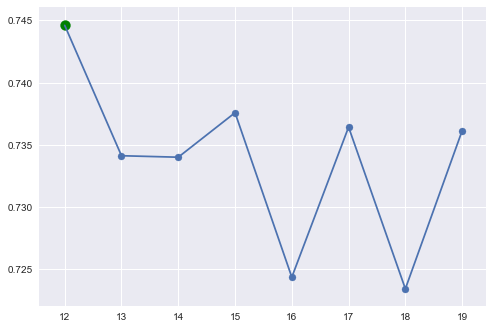

In [30]:
scores = [x.mean_validation_score for x in gridsearch.grid_scores_ if x.parameters['min_samples_leaf']==1]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmax(scores)
plt.scatter(depths[best_point], scores[best_point], c='g', s=100)

In [31]:
clf = DecisionTreeClassifier(max_depth=12, min_samples_leaf=1)

In [32]:
%%time
clf.fit(X_train, y_train)

CPU times: user 799 ms, sys: 13.9 ms, total: 813 ms
Wall time: 811 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [33]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

In [34]:
from sklearn import metrics

In [35]:
metrics.accuracy_score(y_test, y_pred)

0.72894736842105268

In [36]:
metrics.precision_score(y_test, y_pred)

0.73837209302325579

In [37]:
metrics.recall_score(y_test, y_pred)

0.68648648648648647

In [38]:
metrics.f1_score(y_test, y_pred)

0.71148459383753493

In [39]:
metrics.roc_auc_score(y_test, y_pred_proba[:,1])

0.73061677061677066

In [40]:
fpr, tpr, thres = metrics.roc_curve( y_test, y_pred_proba[:, 1] )

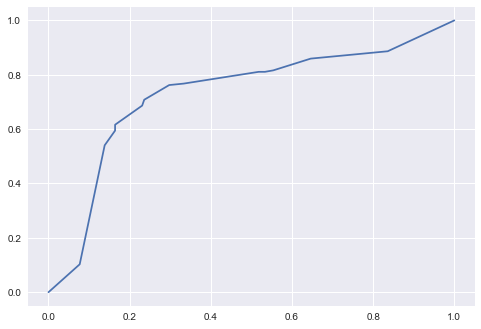

In [41]:
plt.plot( fpr, tpr )

Качество не фатастическое, но хотя бы лучше константного предсказания :)

In [42]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [43]:
get_tree_dot_view(clf, vectorizer.get_feature_names(), ['Матвеев','Колесов'])

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="num <= 0.5\ngini = 0.4998\nsamples = 1518\nvalue = [743, 775]\nclass = Колесов", fillcolor="#399de50b"] ;
1 [label="это <= 0.5\ngini = 0.4677\nsamples = 917\nvalue = [575, 342]\nclass = Матвеев", fillcolor="#e5813967"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="что <= 0.5\ngini = 0.4931\nsamples = 639\nvalue = [357, 282]\nclass = Матвеев", fillcolor="#e5813936"] ;
1 -> 2 ;
3 [label="не <= 0.5\ngini = 0.4994\nsamples = 416\nvalue = [201, 215]\nclass = Колесов", fillcolor="#399de511"] ;
2 -> 3 ;
4 [label="известный <= 0.5\ngini = 0.4929\nsamples = 352\nvalue = [155, 197]\nclass = Колесов", fillcolor="#399de536"] ;
3 -> 4 ;
5 [label="назвать <= 0.5\ngini = 0.4829\nsamples = 324\nvalue = [132, 192]\nclass = Колесов", fillcolor="#399de550"] ;
4 -> 5 ;
6 [label="два <= 0.5\ngini = 0.4999\nsamples = 170\nvalue = [86, 84]\nclass = Матвеев", fillcolor="#e5813906"] ;
5 -> 6 ;
7 [label="восст

In [44]:
def get_top_indexes(s):
    return sorted(range(len(s)), key=lambda k: s[k], reverse=True)

In [45]:
feature_names = vectorizer.get_feature_names()

In [46]:
top_indexes = get_top_indexes(clf.feature_importances_)
top_indexes = top_indexes[:10]
top_indexes.reverse()

In [47]:
top_importances = [clf.feature_importances_[i] for i in top_indexes]
top_words = [feature_names[i] for i in top_indexes]

''

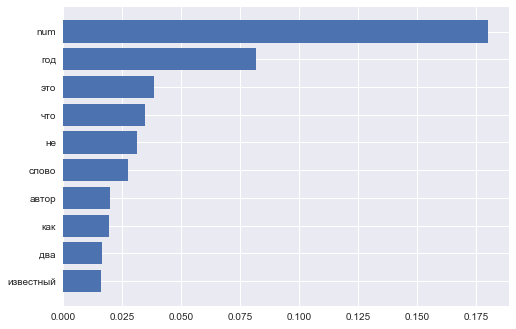

In [49]:
plt.barh(np.arange(len(top_importances)), top_importances)
plt.yticks(np.arange(len(top_words)), top_words)
''

Очевидно, один из авторов любит "исторические" вопросы с упоминанием дат.